### Installing Dependencies and Importing them

In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [2]:
# pip install tensorflow==2.10.1

In [3]:
import os
import cv2 as cv
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

### To use our GPU

In [4]:
physical_device = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth = (physical_device[0], True)
except:
    pass

In [5]:
def load_video(path:str) -> List[float]:
    cap = cv.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:230,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
        
        # Standard normalization (or standardization) transforms
        #data such that it has a mean of zero and a standard deviation of one.
    return tf.cast((frames-mean), tf.float32)/ std       

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!0123456789 "]


In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =41)


In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, " ", line[2]]
            
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), shape=[-1]))
      

In [9]:
tf.version

<module 'tensorflow._api.v2.version' from 'n:\\dummy major project\\lipread\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

In [10]:
def load_data(path: tf.Tensor):
    path = path.numpy().decode("utf-8")  # Proper decoding
    
    # Extract filename without extension
    file_name = os.path.splitext(os.path.basename(path))[0]

    # Use the original path directly for video
    video_path = path
    
    # Construct correct alignment path
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')

    # Optional debug check
    if not os.path.exists(alignment_path):
        raise FileNotFoundError(f"Missing alignment file: {alignment_path}")
    
    # Load video frames and alignments
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [11]:
test_path = 'data/s1/bbaz4n.mpg'

In [12]:
frames , alignments = load_data(tf.convert_to_tensor(test_path))

In [13]:
frames.shape

TensorShape([75, 40, 140, 1])

In [14]:
alignments.shape

TensorShape([23])

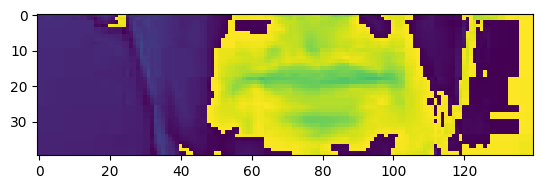

In [15]:
plt.imshow(frames[0])

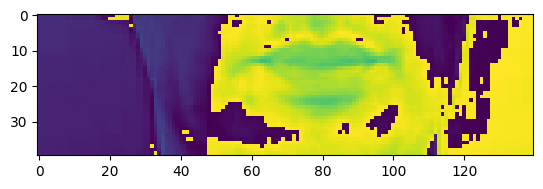

In [16]:
plt.imshow(frames[25])

In [17]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at z four now'>

In [18]:
def mappable_function(path:str) -> List[str]:     # tensorflow piple requires us to use this py_function
    result = tf.py_function(load_data,[path],(tf.float32,tf.int64))
    return result

### Creating Data Pipeline

In [19]:
data = tf.data.Dataset.list_files("data/s1/*.mpg")
data = data.shuffle(500, reshuffle_each_iteration = False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))    # lenght of each alignmets is going to be diffrent so we have padded it to make its lengh same for all 
data = data.prefetch(tf.data.AUTOTUNE)    # prefetchs data batches asynchronously during model training

train = data.take(450)
test = data.skip(450)

In [20]:
len(test)

50

In [21]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [22]:
len(data)

500

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)   ## now we have 2 videos in each batch

2

In [25]:
test = data.as_numpy_iterator()

In [26]:
val = test.next(); val[0]

array([[[[[ 1.3043154 ],
          [ 1.3043154 ],
          [ 1.3043154 ],
          ...,
          [10.039276  ],
          [10.039276  ],
          [10.039276  ]],

         [[ 1.3043154 ],
          [ 1.3043154 ],
          [ 1.3043154 ],
          ...,
          [10.039276  ],
          [10.039276  ],
          [10.039276  ]],

         [[ 1.2647907 ],
          [ 1.2647907 ],
          [ 1.2647907 ],
          ...,
          [10.078801  ],
          [10.078801  ],
          [10.078801  ]],

         ...,

         [[ 0.948593  ],
          [ 0.948593  ],
          [ 0.948593  ],
          ...,
          [ 9.841653  ],
          [ 9.841653  ],
          [ 9.841653  ]],

         [[ 0.948593  ],
          [ 0.948593  ],
          [ 0.948593  ],
          ...,
          [ 9.841653  ],
          [ 9.841653  ],
          [ 9.841653  ]],

         [[ 0.948593  ],
          [ 0.948593  ],
          [ 0.948593  ],
          ...,
          [ 9.841653  ],
          [ 9.841653  ],
          

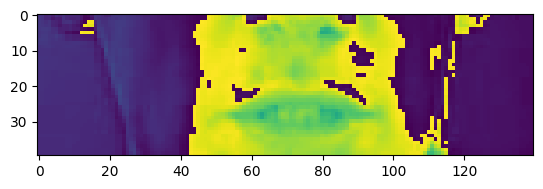

In [27]:
plt.imshow(val[0][1][24])

In [28]:
len(val[0][1])
print(val[0][1])

[[[[1.5052092 ]
   [1.467579  ]
   [0.9031255 ]
   ...
   [0.3763023 ]
   [0.33867207]
   [0.33867207]]

  [[1.4299488 ]
   [1.2417976 ]
   [0.82786506]
   ...
   [0.3763023 ]
   [0.33867207]
   [0.33867207]]

  [[1.3546883 ]
   [1.5428394 ]
   [1.467579  ]
   ...
   [0.3763023 ]
   [0.3763023 ]
   [0.3763023 ]]

  ...

  [[1.128907  ]
   [1.128907  ]
   [1.128907  ]
   ...
   [0.2634116 ]
   [0.2634116 ]
   [0.2634116 ]]

  [[1.128907  ]
   [1.128907  ]
   [1.128907  ]
   ...
   [0.18815115]
   [0.18815115]
   [0.18815115]]

  [[1.128907  ]
   [1.128907  ]
   [1.128907  ]
   ...
   [0.18815115]
   [0.15052092]
   [0.15052092]]]


 [[[1.4299488 ]
   [1.3923185 ]
   [0.978386  ]
   ...
   [0.3763023 ]
   [0.30104184]
   [0.30104184]]

  [[1.3923185 ]
   [1.2794279 ]
   [0.9031255 ]
   ...
   [0.3763023 ]
   [0.30104184]
   [0.30104184]]

  [[1.4299488 ]
   [1.4299488 ]
   [1.2794279 ]
   ...
   [0.33867207]
   [0.33867207]
   [0.33867207]]

  ...

  [[1.128907  ]
   [1.128907  ]
   [1.1

In [29]:
import os

directory = 'animations'

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created successfully.")
else:
    print(f"Directory '{directory}' already exists.")


Directory 'animations' already exists.


In [30]:
import numpy as np
import imageio

video_frames = val[0][1]

# Ensure frames are in the correct shape and format for an animation
video_frames = np.squeeze(video_frames)

num_frames, height, width = video_frames.shape
video_frames_uint8 = (video_frames * 255).astype(np.uint8)
video_frames_reshaped = np.reshape(video_frames_uint8, (num_frames, height, width))

output_path = "animations/animation.gif"
imageio.mimsave('animations/animation.gif', video_frames_reshaped, fps=10)

print(f"Animation saved successfully to: {output_path}")


Animation saved successfully to: animations/animation.gif


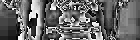

In [31]:
from IPython.display import Image

# Specify the path to your saved GIF
gif_path = 'animations/animation.gif'

# Display the GIF
Image(filename=gif_path, width=400, height=300 , )


In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' lay white at e nine soon'>

### Designing the Deep Neural Netwok


In [33]:
# pip install --upgrade tensorflow 
#  run this cell just in case 

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 40, 140, 1)

In [36]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [37]:
model = Sequential()
model.add(Conv3D(128, (3, 3, 3), input_shape=(75, 40, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))


# model.add(TimeDistributed(Flatten()))
model.add(Reshape(( 75, -1)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer="he_normal", activation="softmax"))

# model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer="he_normal", activation="softmax"))


n:\dummy major project\lipread\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 40, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 40, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 20, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 20, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 20, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 10, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 10, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 10, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 42)         │        10,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,472,181 (32.32 MB)

 Trainable params: 8,472,181 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jj111gggggggggggggggggggggggggggggggggggggggggggggggggggggg1111111111gggeee'>

In [41]:
model.input_shape

(None, 75, 40, 140, 1)

In [42]:
model.output_shape

(None, 75, 42)

###  Seting up Traing options and Train the Model

In [43]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [44]:
def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    
    input_length = input_length * tf.ones(shape=(batch_len,1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
    
    

In [45]:
class produce_example(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))




class ProduceExampleCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset):
        super(ProduceExampleCallback, self).__init__()
        self.dataset = dataset  # Assuming `dataset` is a TensorFlow dataset object

    def on_epoch_end(self, epoch, logs=None):
        # Get a batch of data from the dataset
        data = next(iter(self.dataset.batch(1)))

        inputs, targets = data[0], data[1]

        # Make predictions using the model
        predictions = self.model.predict(inputs)

        # Decode predictions and targets to text
        decoded_targets = tf.strings.reduce_join([vocab[word] + " " for word in targets[0]]).numpy().decode('utf-8')
        decoded_predictions = tf.strings.reduce_join([vocab[word] + " " for word in predictions[0]]).numpy().decode('utf-8')

        # Print original and predicted text
        print(f"Original: {decoded_targets}")
        print(f"Prediction: {decoded_predictions}")
        print("-" * 50)


In [46]:
from tensorflow.keras.optimizers import Adam

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTC_loss)

In [48]:
# !rm Models

In [49]:
!mkdir models

A subdirectory or file models already exists.


In [50]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [51]:
schedule_callback = LearningRateScheduler(scheduler)

In [52]:
test

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001A4353345B0>)

In [53]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [54]:
test

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x000001A4353345B0>)

In [55]:
# example_callback = produce_example(test)


In [57]:
checkpoint_path = 'models/checkpoint.weights.h5'
model.load_weights(checkpoint_path)

# Optionally, print model summary to inspect the loaded model architecture
model.summary()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models\checkpoint.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### Model training Done

In [ ]:
# Model trained to 60 epoches 
model.fit(train,validation_data = test, epochs=29, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/29

 31/450 ━━━━━━━━━━━━━━━━━━━━ 1:14:21 11s/step - loss: 153.3007

### Testing the model


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

#### testing on a vedio 

In [ ]:
sample = load_data(tf.convert_to_tensor('/kaggle/input/lipnet/LipNet/s1/bbal6n.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]